In [1]:
using Base.Threads

using Random
using Distributions
using DifferentialEquations
using Plots

function sample_normal_distribution(mean, std)
    dim = size(mean)[1]
    sample = zeros(Float32, dim)
    for i in 1:dim
        sample[i] = rand(Normal(mean[i], std[i]))
    end
    return sample
end

sample_normal_distribution (generic function with 1 method)

In [2]:
function python_syntax_to_julia(function_strs)
    """
    Replace symbolic constants with their numerical values.
    """
    function_strs = replace.(function_strs, "**" => "^")
    function_strs = replace.(function_strs, "E" => string(exp(1)))
    function_strs = replace.(function_strs, "euler_gamma" => string(0.5772157))

    for i in 0:5
        function_strs = replace.(function_strs, "x_$i" => "u[$(i+1)]")
    end

    return function_strs
end

python_syntax_to_julia (generic function with 1 method)

In [5]:
function python_functions_to_julia_g(g_strs, idx)
    """
    Based on a list of strings of functions in python syntax, create a julia function with a unique name.
    """
    g_strs = python_syntax_to_julia(g_strs)

    # Parse each expression
    exprs = Meta.parse.(g_strs)

    # Generate the function name dynamically
    func_name = Symbol("g_eval_$(idx)!")

    # Generate the function dynamically
    g_eval! = eval(quote
        function $(func_name)(du, u, p, t)
            $(Expr(:block, [:(du[$i] = $(exprs[i])) for i in 1:Base.length(exprs)]...))
        end
        $(func_name)
    end)
    return g_eval!
end

python_functions_to_julia_g (generic function with 1 method)

In [4]:
function python_functions_to_julia_g_resc(g_strs, idx, diffusion_constants)
    """
    Based on a list of strings of functions in python syntax, create a julia function with a unique name.
    """
    g_strs = python_syntax_to_julia(g_strs)

    # Parse each expression
    exprs = Meta.parse.(g_strs)

    a, b, c = diffusion_constants

    # Generate the function name dynamically
    func_name = Symbol("g_eval_resc_$(idx)!")

    # Generate the function dynamically
    g_eval_resc! = eval(quote
        function $(func_name)(du, u, p, t)
            $(Expr(:block, [:(du[$i] = $(exprs[i])) for i in 1:Base.length(exprs)]...))
            @. du = (du - $a) * $b + $c
        end
        $(func_name)
    end)
    return g_eval_resc!
end

python_functions_to_julia_g_resc (generic function with 1 method)

In [6]:
function compile_functions(function_strs; is_f=true)
    functions = Vector{Function}()
    if is_f
        for i in 1:Base.length(function_strs)
            func = python_functions_to_julia_f(function_strs[i], i)
            push!(functions, func)

        end
    else
        for i in 1:Base.length(function_strs)
            func = python_functions_to_julia_g(function_strs[i], i)
            push!(functions, func)

        end
    end

    return functions
end

compile_functions (generic function with 1 method)

In [17]:


# f(u, p, t) = 0.3205 .* u
f(u, p, t) = 0.3022 .* u .+ 0.5187 .* sin.(-0.7129 .+ 1.7655 .* u)

# f(u, p, t) = 0.8502 .* sin.(0.8803 .+ 0.3450 .* u) .- 0.7124 .* sin.(-1.3364 .+ 1.5050 .* u)

g_str = [["0.6332 * sin(-1.3967 + 0.6274 * x_0) + -0.5743 * x_0"]]
# g_str = [["0.9805 * (1 + -0.8580 * x_0)**2 + -0.7564 * x_0"]]
diffusion_functions = compile_functions(g_str; is_f=false)
function check_if_ode_is_valid(sol; max_val_threshold=100, oscillation_threshold=1e-3, oscillation_discard_probability=0.9, use_ode_former_filters=true)
    if sol.retcode != :Success
        return false
    end
    if use_ode_former_filters
        if maximum(abs.(sol)) > max_val_threshold
            return false
        end
        last_quarter_idx = Int(floor(3 * size(sol, 2) / 4))
        if any(maximum(sol[:, last_quarter_idx:size(sol, 2)]) - minimum(sol[:, last_quarter_idx:size(sol, 2)]) .< oscillation_threshold)
            # Return false with a probability of 90%
            if rand() < oscillation_discard_probability
                return false
            end
        end
    end
    return true
end

function get_ODE_trajectories(num_paths, init_conditions_params, tspan, p; method=Euler(), invalid_paths_threshold=5)
    sols = []
    total_paths = 0
    invalid_paths = 0
    while total_paths < num_paths
        initial_condition = sample_normal_distribution(init_conditions_params[1], init_conditions_params[2])
        @info "Initial condition: $initial_condition"
        prob = ODEProblem(f, initial_condition, tspan, p, dt=0.01)
        try
            sol = Base.invokelatest(solve, prob, method)
            if !check_if_ode_is_valid(sol)
                invalid_paths += 1
                if invalid_paths >= invalid_paths_threshold
                    @warn "Skiping ODE solution. Number of valid paths: $total_paths number of invalid paths: $invalid_paths"
                    return nothing
                end
                continue
            end
            push!(sols, sol)
            total_paths += 1
        catch e
            @info e
            invalid_paths += 1
            if invalid_paths >= invalid_paths_threshold
                @warn "Skiping ODE solution. Number of valid paths: $total_paths number of invalid paths: $invalid_paths"
                return nothing
            end
            continue
        end
    end
    return sols
end

get_ODE_trajectories (generic function with 1 method)

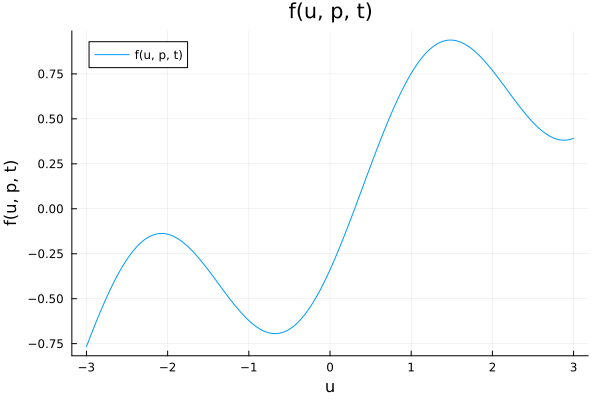

In [8]:
u = range(-3, stop=3, length=1000)
p = []  # parameters
t = 0.0  # time

result = f(u, p, t)
plot(u, result, label="f(u, p, t)", xlabel="u", ylabel="f(u, p, t)", title="f(u, p, t)")

In [25]:
num_paths = 1
sols = get_ODE_trajectories(num_paths, [[0.0], [0.1]], (-3., 3.), [1, [f]])
@info size(sols)

┌ Info: Initial condition: Float32[-0.012129059]
└ @ Main /home/cvejoski/Projects/FoundationModels/Wiener-Procs-FM/wienerfm/data_generation/SDE_solver/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:36
┌ Info: (1,)
└ @ Main /home/cvejoski/Projects/FoundationModels/Wiener-Procs-FM/wienerfm/data_generation/SDE_solver/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:3


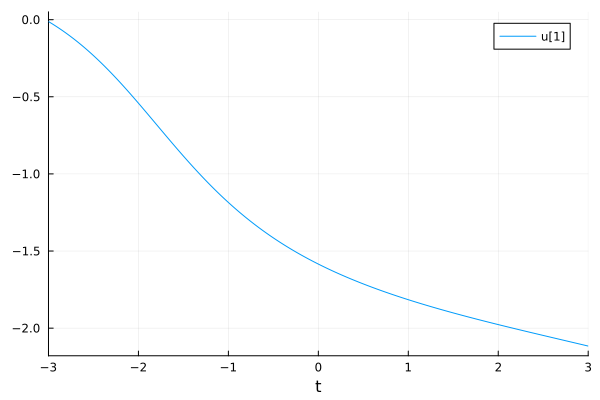

In [26]:
using Plots

plot()
# Plot additional lines
for i in 1:length(sols)
    plot!(sols[i], linewidth=1)
end

plot!()  # Show the plot


In [ ]:
num_dims = 1
SNR_upper = rand(Uniform(50, 100), num_dims)
SNR_lower = similar(SNR_upper)
for i in 1:num_dims
    SNR_lower[i] = rand(Uniform(1, SNR_upper[i]))
end
max_ode_variation = [maximum(maximum(view(sol, d, :)) - minimum(view(sol, d, :)) for sol in sols) for d in 1:num_dims]
g_upper = max_ode_variation ./ SNR_lower
g_lower = max_ode_variation ./ SNR_upper

diffusion_function = diffusion_functions[1]
# Evaluate the diffusion function on the solutions
g_vals = []
for i in 1:num_paths
    grid = sols[i].t
    grid_size = Base.length(grid)
    for j in 1:grid_size
        tmp = zeros(Float32, num_dims)
        Base.invokelatest(diffusion_function, tmp, sols[i][:, j], nothing, grid[j])
        push!(g_vals, tmp)
    end
end
g_vals = hcat(g_vals...)
g_max = [maximum(view(g_vals, d, :)) for d in 1:num_dims]
g_min = [minimum(view(g_vals, d, :)) for d in 1:num_dims]
a = g_min
b = similar(a)
@. b = (g_upper - g_lower) / (g_max - g_min)
c = g_lower

In [ ]:
diffusion_constants = a, b, c
# g_resc = python_functions_to_julia_g_resc(g_str[1], 1, diffusion_constants)
g_resc(u, p, t) = (0.6332 .* sin.(-1.3967 .+ 0.6274 .* u) + -0.5743 .* u .- a) .* b .+ c
# g_resc(u, p, t) = (0.9805 .* (1 .- 0.8580 .* u).^2 -0.7564 .* u .- a) .* b .+ c


In [ ]:
function get_SDE_trajectories(num_paths, init_conditions_params, tspan, dts, dts_eval, p; method=EM(), invalid_paths_threshold=5)
    total_paths = 0
    invalid_paths = 0
    sols = []
    while total_paths < num_paths
        initial_condition = sample_normal_distribution(init_conditions_params[1], init_conditions_params[2])
        prob = SDEProblem(f, g_resc, initial_condition, tspan, p)
        try
            sol = Base.invokelatest(solve, prob, method; dt=dts, saveat=dts_eval)
            if sol === nothing || sol.retcode != :Success
                invalid_paths += 1
                continue
            end
            # Check for infs and nans
            if any(isinf.(sol)) || any(isnan.(sol))
                invalid_paths += 1
                continue
            end
            push!(sols, sol)
            total_paths += 1
        catch e
            invalid_paths += 1
            @warn "Error in solving SDE: $e"
            continue
        end
        if invalid_paths >= invalid_paths_threshold
            @warn "Skiping SDE solution. Number of valid paths: $total_paths number of invalid paths: $invalid_paths"
            return nothing
        end
    end
    return sols
end

In [ ]:
dts = 1/648

In [ ]:
sde_sols = get_SDE_trajectories(num_paths, [[0.0], [0.1]], (1.0, 10.0), 0.0140625, 0.09, [1])

In [ ]:

plot()
for i in 1:length(sde_sols)
    plot!(sde_sols[i])
end
plot!()  # Show the plot